# 코드 설명
1. Data Split EDA
2. 데이터 전처리 - 여기서 부터 실행시키면 됩니다.
3. 최종 데이터 split

In [1]:
import os

import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import pickle
from nltk.tokenize import RegexpTokenizer

import matplotlib.pyplot as plt
%matplotlib inline

# pandas options
pd.set_option('mode.copy_on_write', True)  # pandas 2.0
pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:.4f}'.format  # pd.reset_option('display.float_format')

# NumPy options
np.set_printoptions(precision = 2, suppress=True)  # suppress scientific notation

In [2]:
recomd = pd.read_csv('inter.csv')

In [3]:
item = pd.read_csv('item.csv')

In [4]:
recomd.rename(columns={"app_id": "item_id"}, inplace=True)

# 1. Data Split EDA

In [5]:
recomd["user_id"].nunique() 

680812

In [6]:
item_group = recomd.sort_values(by=['item_id','date'])

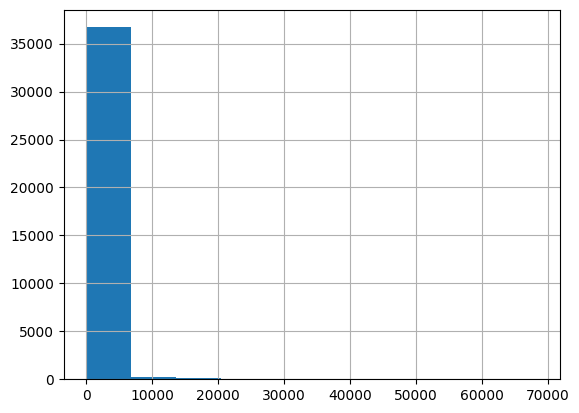

In [7]:
item_count = recomd.groupby('item_id').size().reset_index(name = 'count')
item_count['count'].hist()
plt.show()

In [8]:
# 상위 20% 아이템
threshold = item_count['count'].quantile(0.8)
print(f"임계값 (상위 20%): {threshold}")

임계값 (상위 20%): 163.0


In [9]:
# Old Items와 New Items 분리 - 상위 20% 기준으로
item_count['category'] = item_count['count'].apply(
    lambda x: 'Old' if x >= threshold else ('New' if x >= 30 else 'Other')
)

old_items = item_count[item_count['category'] == 'Old']
new_items = item_count[item_count['category'] == 'New']

In [10]:
item_count['category'].value_counts()


category
Other    19496
New      10214
Old       7431
Name: count, dtype: int64

In [11]:
new_ids = new_items['item_id']
new_df  = item_group[item_group['item_id'].isin(new_ids)]

old_ids = old_items['item_id']
old_df = item_group[item_group['item_id'].isin(old_ids)]

In [12]:
new2count = new_df.groupby('item_id').size().reset_index(name = 'count')
old2count = old_df.groupby('item_id').size().reset_index(name = 'count')

In [63]:
new2count = new2count.merge(item, on="item_id", how="left")
old2count = old2count.merge(item, on="item_id", how="left")


In [15]:
new2count['date_release'] = pd.to_datetime(new2count['date_release'])
old2count['date_release'] = pd.to_datetime(old2count['date_release'])

In [16]:
new2count['year'] = new2count['date_release'].dt.year
old2count['year'] = old2count['date_release'].dt.year

---

# 데이터 EDA

In [17]:
new2count = new2count[new2count['year'] >= 2020]

In [20]:
new2count['categories']

0        Single-player, Multi-player, PvP, Online PvP, ...
76                                           Single-player
537      Single-player, Multi-player, PvP, Online PvP, ...
748      Single-player, Steam Achievements, Steam Tradi...
846      Single-player, Multi-player, Co-op, Shared/Spl...
                               ...                        
10209                      Single-player, In-App Purchases
10210               Single-player, Full controller support
10211                    Single-player, Steam Achievements
10212                                        Single-player
10213    Single-player, Steam Achievements, Full contro...
Name: categories, Length: 3462, dtype: object

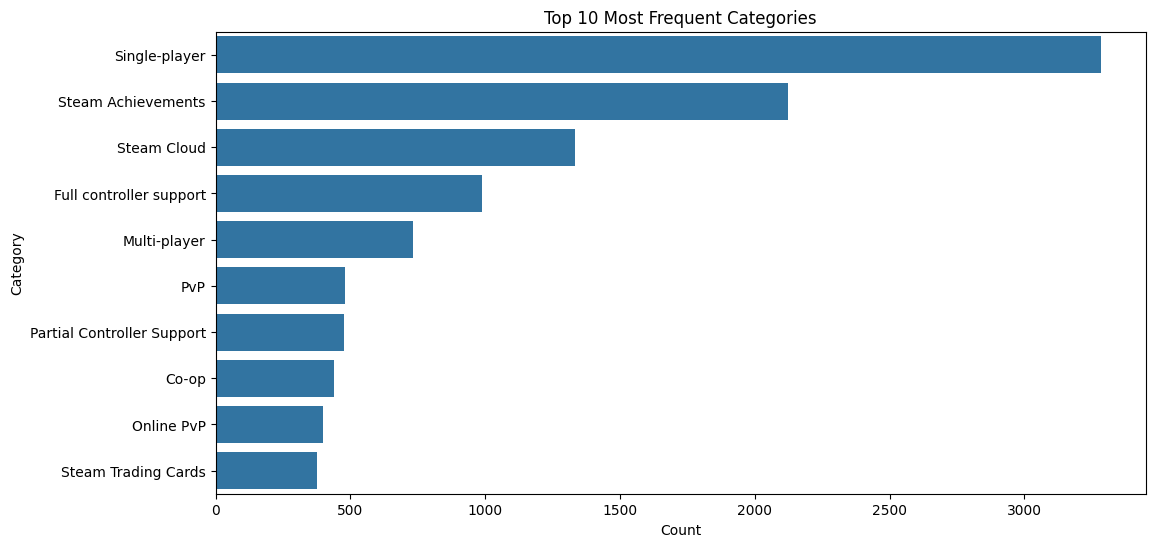

In [30]:
from collections import Counter
import seaborn as sns
# 모든 카테고리를 리스트로 풀어서 카운트
category_list = [cat.strip() for sublist in new2count['categories'].dropna().str.split(',') for cat in sublist]

# 카테고리별 빈도 계산
category_counts = Counter(category_list)

# 데이터프레임으로 변환
category_df = pd.DataFrame(category_counts.items(), columns=['Category', 'Count']).sort_values(by='Count', ascending=False)

# 상위 10개 카테고리 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=category_df['Count'][:10], y=category_df['Category'][:10])
plt.xlabel("Count")
plt.ylabel("Category")
plt.title("Top 10 Most Frequent Categories")
plt.show()


In [31]:
category_df

,Category,Count
0,Single-player,3285
7,Steam Achievements,2124
10,Steam Cloud,1335
8,Full controller support,987
1,Multi-player,731
2,PvP,481
22,Partial Controller Support,478
5,Co-op,441
3,Online PvP,398
9,Steam Trading Cards,377


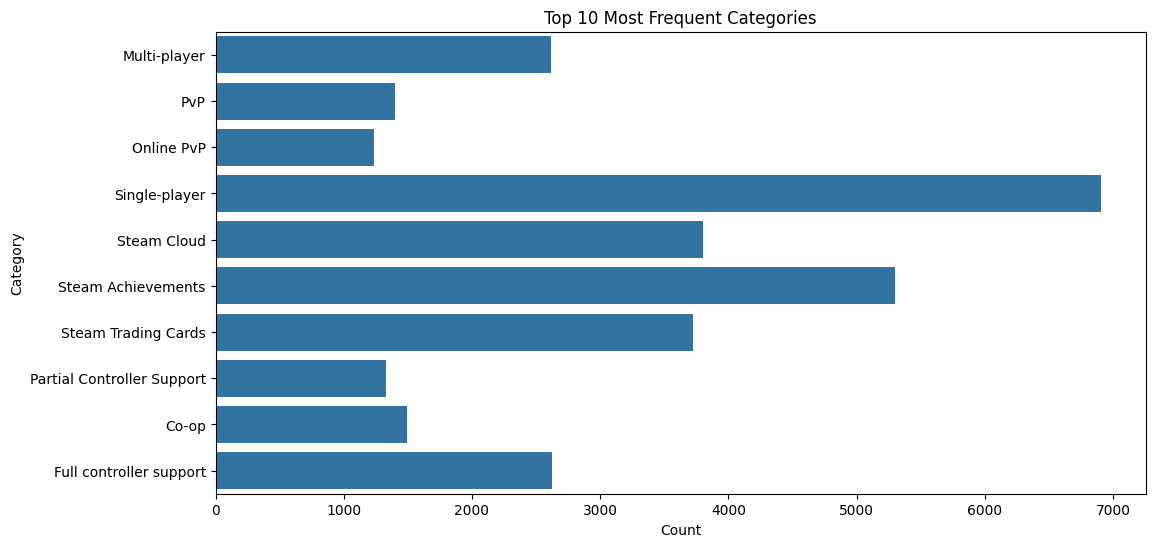

In [32]:
category_list = [cat.strip() for sublist in old2count['categories'].dropna().str.split(',') for cat in sublist]

# 카테고리별 빈도 계산
category_counts = Counter(category_list)

# 데이터프레임으로 변환
category_df = pd.DataFrame(category_counts.items(), columns=['Category', 'Count']).sort_values(by='Count', ascending=False)

# 상위 10개 카테고리 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=category_df['Count'][:20], y=category_df['Category'][:10])
plt.xlabel("Count")
plt.ylabel("Category")
plt.title("Top 10 Most Frequent Categories")
plt.show()

In [33]:
category_df

,Category,Count
6,Single-player,6908
10,Steam Achievements,5301
7,Steam Cloud,3802
11,Steam Trading Cards,3726
22,Full controller support,2627
0,Multi-player,2613
21,Co-op,1493
1,PvP,1402
13,Partial Controller Support,1332
2,Online PvP,1238


In [49]:
def split_EDA(df_ratings, N=163, K=10):
    user2count = df_ratings.groupby(['item_id']).size().reset_index(name='count').sort_values(by='count')
    item_ids = user2count['item_id'].to_numpy()
    counts = user2count['count'].to_numpy()

    hot_item_ids = item_ids[counts > N]
    cold_item_ids = item_ids[(counts <= N) & (counts >= 4 * K)]

    item_group = df_ratings.groupby('item_id')

    train_base_list = []
    for item_id in hot_item_ids:
        df_hot = item_group.get_group(item_id).sort_values(by='date')
        train_base_list.append(df_hot)

    train_base = pd.concat(train_base_list, ignore_index=True)

    train_warm_a_list, train_warm_b_list, train_warm_c_list,test_list = [], [], [], [] 
    
    for item_id in cold_item_ids:
        df_cold = item_group.get_group(item_id).sort_values(by='date')
        df_cold = df_cold[df_cold['year'] >= 2020]  
        train_warm_a_list.append(df_cold[:K])
        train_warm_b_list.append(df_cold[K:2*K])
        train_warm_c_list.append(df_cold[2*K:3*K])
        #train_warm_d_list.append(df_cold[3*K:4*K])
        test_list.append(df_cold[3*K:6*K])
    
    train_warm_a = pd.concat(train_warm_a_list, ignore_index=True)
    train_warm_b = pd.concat(train_warm_b_list, ignore_index=True)
    train_warm_c = pd.concat(train_warm_c_list, ignore_index=True)
    #train_warm_d = pd.concat(train_warm_d_list, ignore_index=True)
    test = pd.concat(test_list, ignore_index=True)
    
    return train_base,train_warm_a,train_warm_b,train_warm_c,test

In [26]:
df_steam['date_release'] = pd.to_datetime(df_steam['date_release'])
df_steam['year'] = df_steam['date_release'].dt.year

In [109]:
train_warm_a,train_warm_b,train_warm_c,test = split_EDA(df_ratings=df_steam)

In [102]:
test['item_id'].nunique()

1161

In [107]:
train_warm_d['is_recommended'].mean()

0.8063667232597623

In [106]:
test['is_recommended'].mean()

0.7974715710564767

In [64]:
old_df['is_recommended'].mean()

0.8422369958981669

---

In [19]:
new2count['category'] = new2count.apply(lambda x: 
                          'Recent-Low-Interaction' if x['year'] >= 2020 else
                          'Old-Low-Interaction' if x['year'] < 2020 else
                          'Other', axis=1)


In [23]:
import scipy.stats as stats
import pprint

recent_low = new2count[new2count['category'] == 'Recent-Low-Interaction']['rating_encoded']
old_low = new2count[new2count['category'] == 'Old-Low-Interaction']['rating_encoded']

# Shapiro-Wilk Test (정규성 검정)
shapiro_recent = stats.shapiro(recent_low)
shapiro_old = stats.shapiro(old_low)

print(f"Shapiro Test for Recent-Low-Interaction: p-value = {shapiro_recent.pvalue}")
print(f"Shapiro Test for Old-Low-Interaction: p-value = {shapiro_old.pvalue}")


Shapiro Test for Recent-Low-Interaction: p-value = 2.1618002688946545e-39
Shapiro Test for Old-Low-Interaction: p-value = 1.1034970729923781e-72


/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9048.
  res = hypotest_fun_out(*samples, **kwds)


In [24]:
years = [2018, 2019, 2020, 2021, 2022]
results = {}

for year in years:
    new2count['category'] = new2count.apply(lambda x: 
                          'Recent-Low-Interaction' if x['year'] >= year else
                          'Old-Low-Interaction' if x['year'] < year else
                          'Other', axis=1)

    recent_low = new2count[new2count['category'] == 'Recent-Low-Interaction']['rating_encoded']
    old_low = new2count[new2count['category'] == 'Old-Low-Interaction']['rating_encoded']
    
    
    u_stat, p_value = stats.mannwhitneyu(recent_low, old_low, alternative='two-sided')

    results[year] = {'U-statistic': u_stat, 'P-value': p_value}

pprint.pprint(results)


{2018: {'P-value': 5.4330485528539285e-136, 'U-statistic': 16264108.0},
 2019: {'P-value': 4.527443288238576e-164, 'U-statistic': 16658589.5},
 2020: {'P-value': 3.484200948514346e-135, 'U-statistic': 14970314.0},
 2021: {'P-value': 1.0651169449003688e-90, 'U-statistic': 11634759.0},
 2022: {'P-value': 6.897759244176819e-47, 'U-statistic': 6556529.5}}


In [173]:
years = [2018, 2019, 2020, 2021, 2022]
results = {}

for year in years:
    new2count['category'] = new2count.apply(lambda x: 
                          'Recent-Low-Interaction' if x['year'] >= year else
                          'Old-Low-Interaction' if x['year'] < year else
                          'Other', axis=1)

    recent_low = new2count[new2count['category'] == 'Recent-Low-Interaction']['positive_ratio']
    old_low = new2count[new2count['category'] == 'Old-Low-Interaction']['positive_ratio']
    

    u_stat, p_value = stats.mannwhitneyu(recent_low, old_low, alternative='two-sided')


    results[year] = {'U-statistic': u_stat, 'P-value': p_value}

pprint.pprint(results)


{2018: {'P-value': 1.2925663395564463e-174, 'U-statistic': 30712573.5},
 2019: {'P-value': 3.7454888565334696e-197, 'U-statistic': 30776015.0},
 2020: {'P-value': 1.2465234058300836e-168, 'U-statistic': 27542972.5},
 2021: {'P-value': 5.0208105415606577e-116, 'U-statistic': 21140633.5},
 2022: {'P-value': 4.759251244071341e-57, 'U-statistic': 11650549.5}}


In [113]:
print('인기 아이템의 출시일시')
print(old2count['year'].describe())
print('인기 없는 아이템의 출시일시')
print(new2count['year'].describe())

인기 아이템의 출시일시
count   3716.0000
mean    2016.7570
std        3.7878
min     1997.0000
25%     2014.0000
50%     2017.0000
75%     2020.0000
max     2023.0000
Name: year, dtype: float64
인기 없는 아이템의 출시일시
count   13929.0000
mean     2017.7175
std         3.0926
min      1997.0000
25%      2016.0000
50%      2018.0000
75%      2020.0000
max      2023.0000
Name: year, dtype: float64


---

# 2. 데이터 scaling/encoding

In [25]:
# date와 hours는 negative sampling으로 인해 사용 불가함
recomd

,user_id,item_id,is_recommended,date,unix_date,hours,helpful,funny
0,0,63710,0,2014-06-16,1402876800,2.0000,4,0
1,0,260230,0,2014-06-25,1403654400,5.5000,12,0
2,0,267060,0,2014-09-02,1409616000,11.5000,6,0
3,0,8850,1,2014-09-08,1410134400,61.5000,8,0
4,0,226960,0,2014-09-22,1411344000,1.0000,7,0
...,...,...,...,...,...,...,...,...
14529069,9999939,1147030,1,2021-10-21,1634774400,0.2000,0,0
14529070,9999939,1141030,1,2021-10-21,1634774400,2.0000,0,0
14529071,9999939,1468260,1,2021-11-24,1637712000,18.3000,0,0
14529072,9999939,1481400,1,2022-03-05,1646438400,0.7000,0,0


In [34]:
df_steam = recomd

In [35]:
df_steam['interaction'] = df_steam['is_recommended'].astype(int)

In [36]:
df_steam['interaction'].value_counts()

interaction
1    12144253
0     2384821
Name: count, dtype: int64

In [36]:
# import numpy as np
# import pandas as pd
# from tqdm import tqdm

# def negative_sampling(train_data):
#     """
#     Memory-efficient Negative Sampling using vectorized operations.
    
#     Args:
#         train_data (DataFrame): Data with columns ['user_id', 'item_id', 'interaction']
#         negative_ratio (int): Number of negative samples per positive sample
    
#     Returns:
#         final_train_data (DataFrame): Positive & Negative samples combined
#     """
    
#     # Positive 데이터 추출
#     interacted_data = train_data
#     positive_data_len = train_data['interaction'].sum()
#     negative_data_len = len(train_data) - positive_data_len

#     # 모든 유저와 아이템 목록 추출
#     unique_users = interacted_data['user_id'].unique()
#     all_items = set(train_data['item_id'].unique())  # Set 연산 최적화

#     # Negative 샘플링
#     negative_samples = []
#     user_groups = interacted_data.groupby('user_id')['item_id'].apply(set).to_dict()  # 유저별 상호작용 아이템

#     for user_id in tqdm(unique_users, desc="Generating Negative Samples"):
#         interacted_items = user_groups.get(user_id, set())

#         # 해당 유저가 상호작용하지 않은 아이템 중 랜덤 샘플링
#         non_interacted_items = list(all_items - interacted_items)
#         num_samples = min(0, positive_data_len-negative_data_len)  # Negative 샘플 개수

#         if num_samples > 0:
#             sampled_items = np.random.choice(non_interacted_items, num_samples, replace=False)
#             negative_samples.extend(zip([user_id] * num_samples, sampled_items, [0] * num_samples))

#     # Negative 데이터프레임 생성
#     negative_data = pd.DataFrame(negative_samples, columns=['user_id', 'item_id', 'interaction'])

#     # Positive와 Negative 데이터 합치기
#     final_train_data = pd.concat([interacted_data, negative_data], ignore_index=True)
    
#     print("Positive 데이터 개수:", final_train_data['interaction'].value_counts()[1])
#     print("Negative 데이터 개수:", final_train_data['interaction'].value_counts()[0])

#     # 데이터 섞기 (shuffle)
#     final_train_data = final_train_data.sample(frac=1, random_state=42).reset_index(drop=True)

#     return final_train_data


In [39]:
# recomd['interaction'] = recomd['is_recommended'].astype(int)

In [ ]:
# negative_sampled_df = negative_sampling(recomd)

In [37]:
# Load user and item file, join with rating
# df_user = pd.read_csv('users.csv')
df_item = item
# df_steam = df_steam.merge(df_user, on='user_id', how='left')
df_steam = df_steam.merge(df_item, on='item_id', how='left')
df_steam.head(2)

,user_id,item_id,is_recommended,date,unix_date,hours,helpful,funny,interaction,title,date_release,win,mac,linux,positive_ratio,price_final,price_original,steam_deck,estimated_owners,peak_ccu,required_age,price,dlc_count,detailed_description,short_description,supported_languages,metacritic_score,positive,negative,notes,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,developers,publishers,categories,genres,description,tags_sum,rating_encoded,date_release_unix,estimated_owners_mid,review_count
0,0,63710,0,2014-06-16,1402876800,2.0000,4,0,0,BIT.TRIP RUNNER,2011-02-28,1,1,0,87,9.9900,9.9900,1,500000 - 1000000,2.0000,0.0000,9.9900,0.0000,"BIT.TRIP RUNNER is the fastest, most exhilarat...","CommanderVideo is back with BIT.TRIP RUNNER, t...",English,0.0000,3270.0000,530.0000,NaN,170.0000,0.0000,133.0000,0.0000,Gaijin Games,Gaijin Games,"Single-player, Steam Achievements, Full contro...","Action, Indie","CommanderVideo is back with BIT.TRIP RUNNER, t...","2D, Action, Arcade, Casual, Colorful, Controll...",7,1298851200,750000,1278
1,0,260230,0,2014-06-25,1403654400,5.5000,12,0,0,Valiant Hearts: The Great War™ / Soldats Incon...,2014-06-25,1,0,0,95,14.9900,14.9900,1,500000 - 1000000,35.0000,0.0000,14.9900,0.0000,“CHARMING AND DEEPLY MOVING” – IGN “INTRIGUING...,Valiant Hearts : The Great War is the story of...,"English, French, Italian, German, Spanish - Sp...",0.0000,20709.0000,941.0000,NaN,319.0000,0.0000,370.0000,0.0000,Ubisoft Montpellier,Ubisoft,Single-player,Adventure,Valiant Hearts : The Great War is the story of...,"2D, Action, Adventure, Atmospheric, Great Soun...",8,1403654400,750000,5365


In [40]:
df_steam.columns

Index(['user_id', 'item_id', 'is_recommended', 'date', 'unix_date', 'hours',
       'helpful', 'funny', 'interaction', 'title', 'date_release', 'win',
       'mac', 'linux', 'positive_ratio', 'price_final', 'price_original',
       'steam_deck', 'estimated_owners', 'peak_ccu', 'required_age', 'price',
       'dlc_count', 'detailed_description', 'short_description',
       'supported_languages', 'metacritic_score', 'positive', 'negative',
       'notes', 'average_playtime_forever', 'average_playtime_2weeks',
       'median_playtime_forever', 'median_playtime_2weeks', 'developers',
       'publishers', 'categories', 'genres', 'description', 'tags_sum',
       'rating_encoded', 'date_release_unix', 'estimated_owners_mid',
       'review_count'],
      dtype='object')

In [41]:
df_steam['hours'].describe()

count   14529074.0000
mean          63.5227
std          132.7037
min            0.0000
25%            4.8000
50%           15.9000
75%           53.1000
max         1000.0000
Name: hours, dtype: float64

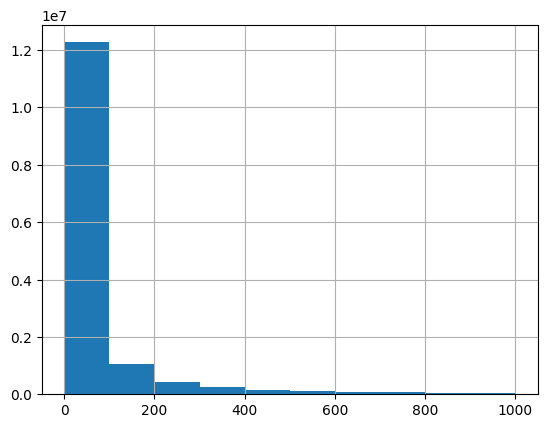

In [46]:
df_steam['hours'].hist()
plt.show()

In [42]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df_steam['hours_scaled'] = scaler.fit_transform(df_steam[['hours']])

In [65]:
df_steam['hours'].describe()

count   14529074.0000
mean          63.5227
std          132.7037
min            0.0000
25%            4.8000
50%           15.9000
75%           53.1000
max         1000.0000
Name: hours, dtype: float64

In [44]:
df_steam['hours_scaled'].describe()

count   14529074.0000
mean           0.9860
std            2.7475
min           -0.3292
25%           -0.2298
50%            0.0000
75%            0.7702
max           20.3747
Name: hours_scaled, dtype: float64

In [45]:
df_steam['hours_log_scaled'] = np.log1p(df_steam['hours'])

df_steam['hours_log_scaled'].describe()


count   14529074.0000
mean           2.9226
std            1.5731
min            0.0000
25%            1.7579
50%            2.8273
75%            3.9908
max            6.9088
Name: hours_log_scaled, dtype: float64

In [47]:
# Preprocess hours - minmax scaling
min_hours = df_steam['hours'].min()
max_hours = df_steam['hours'].max()
df_steam['min_max_hours'] = (df_steam['hours'] - min_hours) / (max_hours - min_hours)

In [48]:
df_steam['min_max_hours'].describe()

count   14529074.0000
mean           0.0635
std            0.1327
min            0.0000
25%            0.0048
50%            0.0159
75%            0.0531
max            1.0000
Name: min_max_hours, dtype: float64

In [51]:
df_steam['date_release'] = pd.to_datetime(df_steam['date_release'])
df_steam['year'] = df_steam['date_release'].dt.year # 데이터 스플릿을 위한 Year 변수

In [53]:
# Preprocess date - minmax scaling
df_steam['date'] = pd.to_datetime(df_steam['date'])
df_steam['date'] = (df_steam['date'] - pd.Timestamp("1970-01-01")).dt.days
min_date = np.min(df_steam['date'])
max_date = np.max(df_steam['date'])

df_steam['date'] = df_steam['date'].map(lambda x: (x - min_date) / (max_date - min_date))
df_steam = df_steam.sort_values(by='date')  # 시간순 정렬

In [54]:
train_warm_a,train_warm_b,train_warm_c,test = split_EDA(df_ratings=df_steam)

In [68]:
test['hours'].describe()

count   69754.0000
mean       15.3962
std        55.4459
min         0.0000
25%         1.0000
50%         3.6000
75%        10.2000
max       997.5000
Name: hours, dtype: float64

In [65]:
# # Preprocess titles - multi label encoding
# tokenizer = RegexpTokenizer(r'\w+')
# titles = df_steam['title']
# tokenized_titles = []
# titles = [tokenizer.tokenize(str(title)) for title in list(titles)]
# vocab = []
# max_title_len = 0
# for title in titles:
#     vocab += title
#     max_title_len = max_title_len if max_title_len > len(title) else len(title)
# vocab = set(vocab)
# word2idx = {word: idx for idx, word in enumerate(vocab)}
# res_title = []
# for title in titles:
#     padding_title = [word2idx[word] for word in title]
#     padding_title.extend([0 for i in range(max_title_len - len(title))])
#     res_title.append(padding_title)
# df_steam['title'] = res_title
# df_steam['title']

In [66]:
# Preprocess positive_ratio - minmax scaling
df_steam['positive_ratio'] = df_steam['positive_ratio'].map(lambda x: x / 100)

In [67]:
# Preprocess price_final & price_original - minmax scaling
min_price_final = df_steam['price_final'].min()
max_price_final = df_steam['price_final'].max()
df_steam['price_final'] = (df_steam['price_final'] - min_price_final) / (max_price_final - min_price_final)

min_price_original = df_steam['price_original'].min()
max_price_original = df_steam['price_original'].max()
df_steam['price_original'] = (df_steam['price_original'] - min_price_original) / (max_price_original - min_price_original)

In [68]:
# Preprocess peak_ccu - minmax scaling
min_peak_ccu = df_steam['peak_ccu'].min()
max_peak_ccu = df_steam['peak_ccu'].max()
df_steam['peak_ccu'] = (df_steam['peak_ccu'] - min_peak_ccu) / (max_peak_ccu - min_peak_ccu)

In [69]:
# Preprocess required_age - binary encoding: over 16 or not
df_steam["required_age"].value_counts().sort_index()
df_steam['required_age'] = df_steam['required_age'].map(lambda x: 1 if x >= 16 else 0)

In [70]:
# Preprocess price - minmax scaling
min_price = df_steam['price'].min()
max_price = df_steam['price'].max()
df_steam['price'] = (df_steam['price'] - min_price) / (max_price - min_price)

In [ ]:
'''
# Preprocess supported_languages - multi label encoding
df_steam.fillna({"supported_languages": ""}, inplace=True)
supported_languages = df_steam['supported_languages']
lang2idx = {}
cnt = 0
res_lang = []
max_lang_len = 0
for lang_str in supported_languages:
    lang_list = [lang.strip() for part in lang_str.split(",") for lang in part.split("-")]
    max_lang_len = max(max_lang_len, len(lang_list))
    for lang in lang_list:
        if lang not in lang2idx:
            lang2idx[lang] = cnt
            cnt += 1
    res_lang.append([lang2idx[lang] for lang in lang_list])
for lang in res_lang:
    lang.extend([0 for i in range(max_lang_len - len(lang))])
df_steam['supported_languages'] = res_lang
df_steam['supported_languages']
'''

0           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 0, 0...
2           [0, 1, 2, 3, 4, 5, 7, 12, 9, 9, 10, 11, 13, 0,...
3           [0, 1, 3, 2, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                                  ...                        
14529069    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
14529070    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
14529071    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
14529072    [0, 1, 2, 3, 4, 5, 13, 8, 9, 10, 11, 20, 7, 0,...
14529073    [0, 1, 3, 4, 5, 2, 15, 11, 18, 8, 30, 0, 0, 0,...
Name: supported_languages, Length: 14529074, dtype: object

In [72]:
# Preprocess metacritic_score - minmax scaling
df_steam['metacritic_score'] = df_steam['metacritic_score'].map(lambda x: x / 100)


In [73]:
df_steam['date_release'] = pd.to_datetime(df_steam['date_release'])
df_steam['year'] = df_steam['date_release'].dt.year

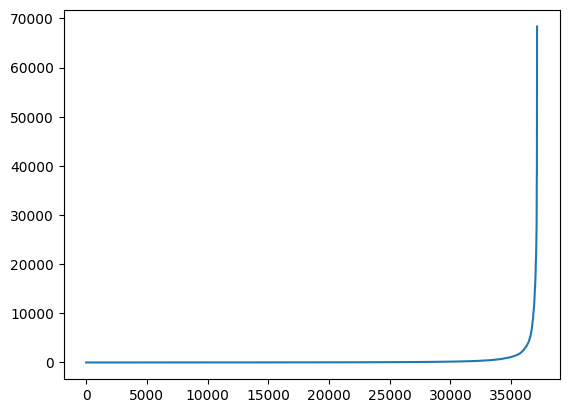

In [74]:
# plot item counts vs item
user2count = df_steam.groupby(['item_id']).size().reset_index(name='count').sort_values(by='count')
item_ids = list(user2count['item_id'])
counts = np.array(user2count['count'])
plt.plot(np.arange(len(counts)), counts)

In [75]:
# Preprocess count
df_steam = df_steam.join(user2count.set_index('item_id'), on='item_id')
min_count = np.min(df_steam['count'])
max_count = np.max(df_steam['count'])
df_steam['count'] = df_steam['count'].map(lambda x: (x - min_count) / (max_count - min_count))

In [76]:
# Preprocess date_release - minmax scaling
df_steam['date_release'] = (df_steam['date_release'] - pd.Timestamp("1970-01-01")).dt.days
min_date = np.min(df_steam['date_release'])
max_date = np.max(df_steam['date_release'])

df_steam['date_release'] = df_steam['date_release'].map(lambda x: (x - min_date) / (max_date - min_date))

In [77]:
# Preprocess date - minmax scaling
df_steam['date'] = pd.to_datetime(df_steam['date'])
df_steam['date'] = (df_steam['date'] - pd.Timestamp("1970-01-01")).dt.days
min_date = np.min(df_steam['date'])
max_date = np.max(df_steam['date'])

df_steam['date'] = df_steam['date'].map(lambda x: (x - min_date) / (max_date - min_date))
df_steam = df_steam.sort_values(by='date')  # 시간순 정렬

In [79]:
# define unique function
def _unique(sample, fname):
    tmp_df = pd.DataFrame()
    tmp_df[fname] = sample[fname].unique()
    num = len(tmp_df)
    tmp_df['tmp_feature'] = range(num)
    sample = sample.join(tmp_df.set_index(fname), on=fname)
    sample.drop(fname, axis=1, inplace=True)
    sample = sample.rename(columns = {"tmp_feature": fname})
    return num, sample

num_user, df_steam = _unique(df_steam, 'user_id')
num_app, df_steam = _unique(df_steam, 'item_id')

# Reorder columns
orders = ['user_id', 'item_id', 'hours', 'date_release', 'positive_ratio', 'price_final', 'price_original', 'peak_ccu', 'required_age', 'price', 'metacritic_score', 'date', 'interaction', 'count','year']
df_steam = df_steam[orders]
description = [
    ('user_id', num_user, 'spr'),  # 변환된 유저 ID
    ('item_id', num_app, 'spr'),  # 변환된 게임(아이템) ID
    ('hours', -1, 'ctn'),  # 플레이 시간
    ('date_release', -1, 'ctn'),  # 출시일
    ('positive_ratio', -1, 'ctn'),  # 긍정적인 평가 비율
    ('price_final', -1, 'ctn'),  # 최종 가격
    ('price_original', -1, 'ctn'),  # 원래 가격
    ('peak_ccu', -1, 'ctn'),  # 최대 동시 접속자 수
    ('required_age', 1 + np.max(df_steam["required_age"]), 'spr'),  # 필요한 나이
    ('price', -1, 'ctn'),  # 가격
    # ('supported_languages', 1 + np.max(list(df_steam["supported_languages"])), 'seq'),  # 지원되는 언어
    ('metacritic_score', -1, 'ctn'),  # 메타크리틱 점수
    ('date', -1, 'ctn'),  # 정규화된 날짜
    ('interaction', 2, 'label'),  # 클릭 여부
    ('count', -1, 'ctn'),  # 리뷰 수
]
description


[('user_id', 680812, 'spr'),
 ('item_id', 37141, 'spr'),
 ('hours', -1, 'ctn'),
 ('date_release', -1, 'ctn'),
 ('positive_ratio', -1, 'ctn'),
 ('price_final', -1, 'ctn'),
 ('price_original', -1, 'ctn'),
 ('peak_ccu', -1, 'ctn'),
 ('required_age', 2, 'spr'),
 ('price', -1, 'ctn'),
 ('metacritic_score', -1, 'ctn'),
 ('date', -1, 'ctn'),
 ('interaction', 2, 'label'),
 ('count', -1, 'ctn')]

In [80]:
df_steam.head(2)

,user_id,item_id,hours,date_release,positive_ratio,price_final,price_original,peak_ccu,required_age,price,metacritic_score,date,interaction,count,year
12739758,0,0,0.4288,0.5087,0.9600,0.0370,0.0000,0.0070,1,0.0370,0.8400,0.0000,1,0.5185,2010
1096052,1,1,0.6228,0.3930,0.9300,0.0000,0.0000,0.1305,0,0.0000,0.9200,0.0000,1,1.0000,2007


# 3. 데이터 Split

In [81]:
def split_2(df_ratings, description, N=163, K=10):
    user2count = df_ratings.groupby(['item_id']).size().reset_index(name='count').sort_values(by='count')
    item_ids = user2count['item_id'].to_numpy()
    counts = user2count['count'].to_numpy()

    hot_item_ids = item_ids[counts > N]
    cold_item_ids = item_ids[(counts <= N) & (counts >= 3 * K)]

    item_group = df_ratings.groupby('item_id')

    train_base_list = []
    for item_id in hot_item_ids:
        df_hot = item_group.get_group(item_id).sort_values(by='date')
        train_base_list.append(df_hot)

    train_base = pd.concat(train_base_list, ignore_index=True)

    train_warm_a_list, train_warm_b_list, train_warm_c_list, test_list = [], [], [], []
    
    for item_id in cold_item_ids:
        df_cold = item_group.get_group(item_id).sort_values(by='date')
        df_cold = df_cold[df_cold['year'] >= 2020]  
        train_warm_a_list.append(df_cold[:K])
        train_warm_b_list.append(df_cold[K:2*K])
        train_warm_c_list.append(df_cold[2*K:3*K])
        test_list.append(df_cold[3*K:])
    
    train_warm_a = pd.concat(train_warm_a_list, ignore_index=True)
    train_warm_b = pd.concat(train_warm_b_list, ignore_index=True)
    train_warm_c = pd.concat(train_warm_c_list, ignore_index=True)
    test = pd.concat(test_list, ignore_index=True)

    save_dic = {
        'train_base': train_base.sort_values('date'),
        'train_warm_a': train_warm_a.sort_values('date'),
        'train_warm_b': train_warm_b.sort_values('date'),
        'train_warm_c': train_warm_c.sort_values('date'),
        'test': test.sort_values('date'),
        'description': description
    }

    for name, df in save_dic.items():
        print("{} size: {}".format(name, len(df)))

    with open('./emb_warm_split_preprocess.pkl', 'bw+') as f:
        pickle.dump(save_dic, f)
